# Transcription Factor Project - Analysis on Strong Perturbation TF KO Dataset
**Robin Anwyl, UCSD Subramaniam Lab**

**Project Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Notebook Description:** 
-  Dataset: QC'd TF KO dataset that will be filtered to include only TF KOs that result in >= 10 DEGs with p-adj < 0.05. 
-  Analysis: pairwise Pearson correlation matrix, minimal distortion embedding (MDE), comparison of cluster membership via Jaccard index
***

# Import statements

In [1]:
import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import gc
#from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
#from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
#import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import pickle as pkl
#import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

# Downstream analysis on strong perturbation TF KO dataset (402 TF KOs)

### Data read-in

Read in TF-KO-only dataset

In [ ]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")

In [ ]:
adata_tfs

AnnData object with n_obs × n_vars = 31808 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Read in set of TFs

In [ ]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Read in differential expression analysis results from TF KO and NTC dataset (85% sample fraction, LFC shrinkage performed with adapt=False)

In [ ]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")

In [ ]:
de_results

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,5.197361,0.603388,0.610262,1.249251,0.211573,NaN,3.271476,-0.219247,0.719732,-0.436204,...,0.928560,-1.333630,0.182325,0.937090,3.431164,-0.557770,0.756780,-1.045982,0.295569,0.943485
A1BG-AS1,2.117718,0.544581,0.911720,0.986719,0.323780,NaN,0.659727,-0.021330,1.140542,-0.048274,...,1.246887,-0.863337,0.387952,0.937090,0.627773,-0.762906,1.404104,-1.112549,0.265902,0.943485
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.349860,-0.390388,1.225741,-0.692164,0.488835,NaN,0.826464,-0.187075,1.073352,-0.401825,...,1.930966,1.844563,0.065101,0.937090,0.643332,0.025018,1.154267,0.060363,0.951867,0.979964
A2M-AS1,0.311871,0.340470,1.828676,0.582373,0.560315,NaN,0.976668,0.678086,1.342768,1.186024,...,1.135588,-0.197266,0.843620,0.937090,0.823219,0.181208,1.157592,0.401337,0.688172,0.943485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,2.281155,-0.062909,0.818718,-0.124417,0.900985,NaN,0.821861,-0.266226,1.104904,-0.863539,...,1.015584,0.093510,0.925499,0.976460,0.983446,-0.264999,1.061158,-0.557942,0.576884,0.943485
ZYG11B,16.388837,0.142245,0.343832,0.448989,0.653440,NaN,11.752263,0.006335,0.420150,0.015429,...,0.528945,1.291485,0.196536,0.937090,16.320781,-0.207652,0.371043,-0.616998,0.537236,0.943485
ZYX,21.191806,0.216751,0.369794,0.644994,0.518931,NaN,15.210018,0.632165,0.390773,1.787083,...,0.617423,-0.192321,0.847491,0.939522,19.662778,0.057214,0.347965,0.177552,0.859075,0.957807
ZZEF1,5.948701,-0.097954,0.543078,-0.223904,0.822832,NaN,6.672568,0.815502,0.579438,1.709801,...,0.726426,0.322776,0.746865,0.937090,6.877744,0.193642,0.556144,0.430629,0.666738,0.943485


## Filter TF KOs that are strong perturbations (result in >= 10 DEGs)

In [ ]:
def tf_ko_strong_perturbations(de_df):
    # Get list of TF KOs in DF
    col_list = de_df.columns.tolist()
    tf_kos = {col.split("_")[0] for col in col_list}
    tf_kos = list(tf_kos)
    # Check for TF KOs with >= 10 DEGs
    strong_perts = list()
    for tf in tf_kos:
        n_degs = len(de_df[de_df[f"{tf}_padj"] < 0.05])
        if n_degs >= 10:
            strong_perts.append(tf)
    return strong_perts

In [ ]:
strong_tf_kos = tf_ko_strong_perturbations(de_results)
print(len(strong_tf_kos))

402


In [ ]:
adata_strong = adata_tfs[adata_tfs.obs.gene_target.isin(strong_tf_kos)].copy()
adata_strong

AnnData object with n_obs × n_vars = 21234 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

## Filter genes expressed in fewer than 25 cells

Filter genes expressed in fewer than 25 cells

In [ ]:
sc.pp.filter_genes(adata_strong, min_cells=25) # Filter for genes that are present in at least 25 cells
adata_strong

filtered out 14330 genes that are detected in less than 25 cells


AnnData object with n_obs × n_vars = 21234 × 23237
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

## Filter genes

In [ ]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25, padj_threshold=0.05):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold
    lfc_degs = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        lfc_degs.update(deg_df.loc[(abs(deg_df[l2fc_col]) > lfc_threshold) 
                                   & (deg_df[padj_col] < padj_threshold)].index)
    return lfc_degs

Filter to genes with |LFC| > 0.25

In [ ]:
degs_filt_25 = filter_degs_lfc(de_results)
print(len(degs_filt_25))

5095


In [ ]:
adata_strong_degs = adata_strong[:, adata_strong.var.index.isin(degs_filt_25)].copy()
adata_strong_degs

AnnData object with n_obs × n_vars = 21234 × 5086
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_strong_degs.write_h5ad("/home/ranwyl/data_tf_project/tf_kos_strong_degs")

Filter to 2000 HVGs

In [ ]:
adata_strong_hvgs = adata_strong.copy()
sc.pp.highly_variable_genes(adata_strong_hvgs, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
adata_strong_hvgs

AnnData object with n_obs × n_vars = 21234 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_strong_hvgs.write_h5ad("/home/ranwyl/data_tf_project/tf_kos_strong_hvgs")

## Pairwise Pearson correlation matrix

In [ ]:
def compute_mean_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    return mean_vector.A1 if hasattr(mean_vector, 'A1') else mean_vector

def tf_create_corrmatrix(adata, v_min=-1, v_max=1, color_map="RdBu"):
    gene_target_groups = adata.obs.groupby('gene_target').indices
    adata_mean_profiles = [compute_mean_profile(adata, indices) for indices in gene_target_groups.values()]
    adata_mean_profiles = np.array(adata_mean_profiles)
    corr_matrix = np.corrcoef(adata_mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_dataframe = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_dataframe, cmap=color_map, xticklabels=False, yticklabels=False, vmax=v_max, vmin=v_min, center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_dataframe, adata_mean_profiles)

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


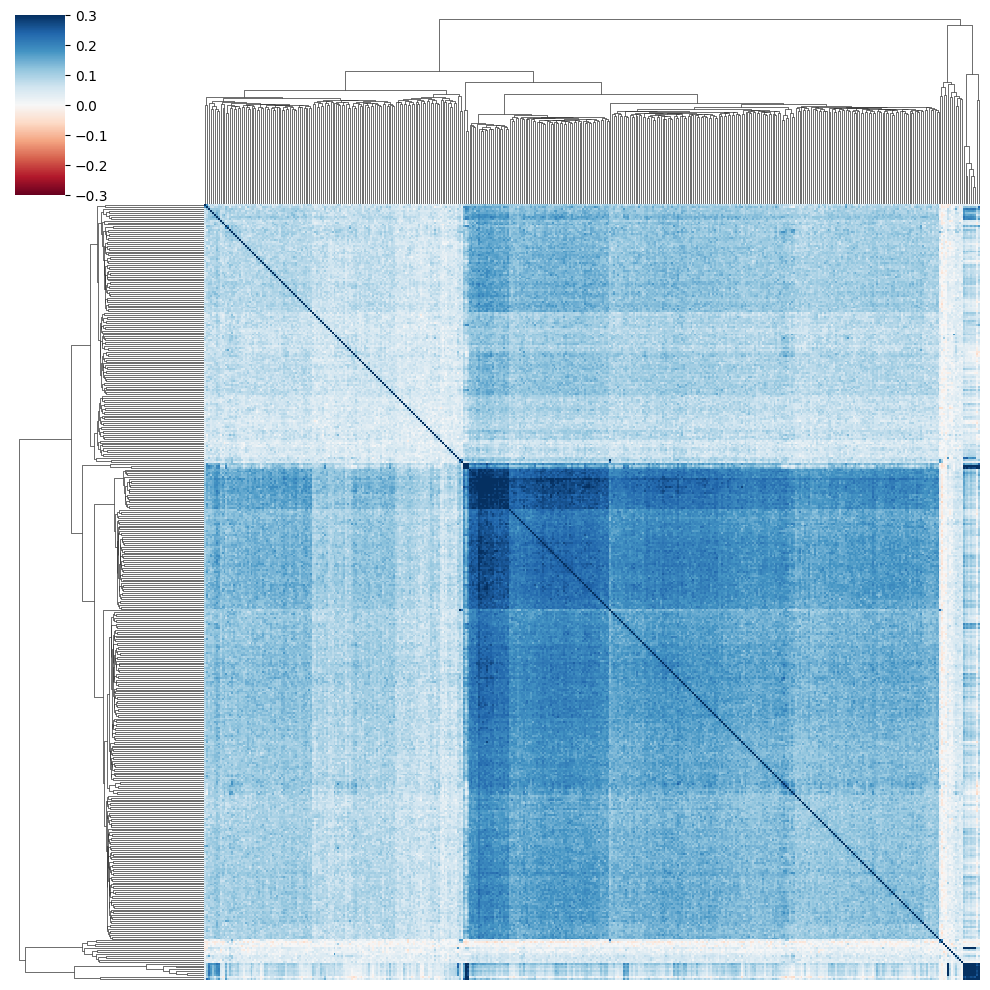

In [ ]:
_ = tf_create_corrmatrix(adata_strong_degs, v_min=-0.3, v_max=0.3)

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


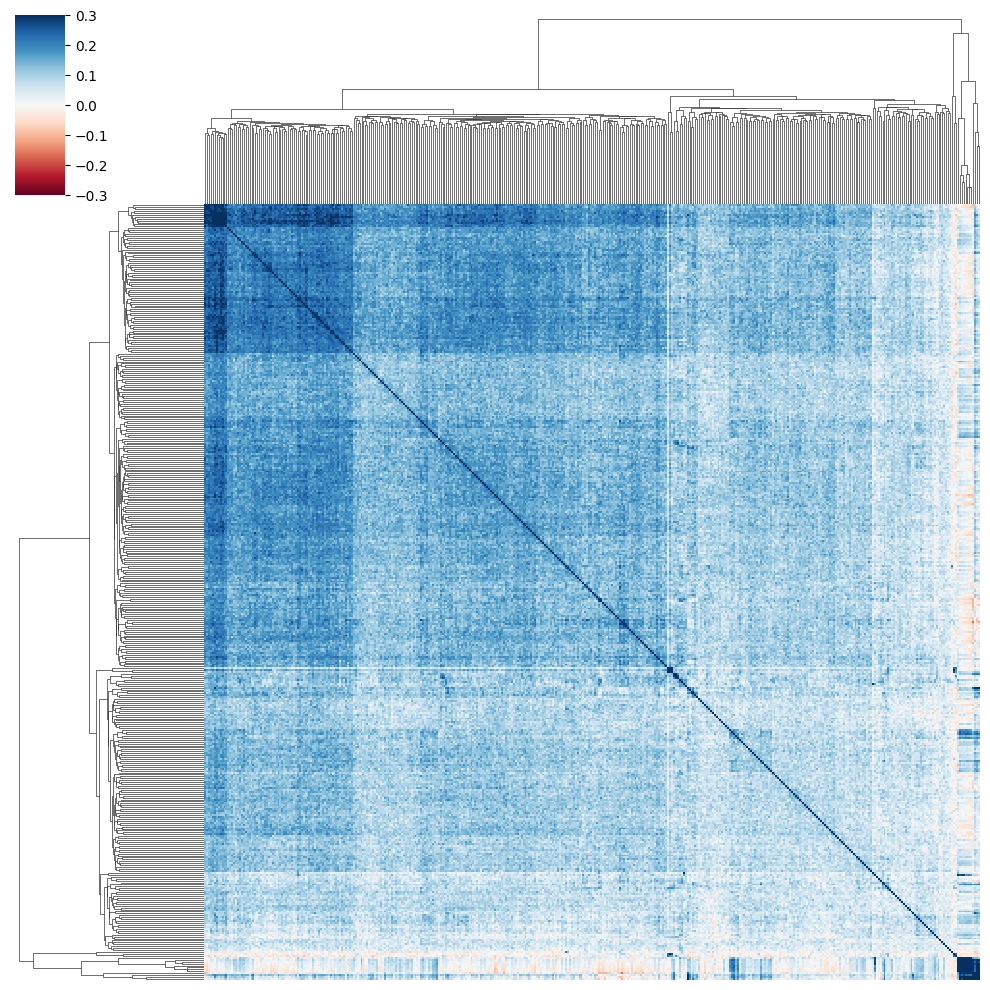

In [ ]:
_ = tf_create_corrmatrix(adata_strong_hvgs, v_min=-0.3, v_max=0.3)

## MDE

### MDE function

In [ ]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def tf_compute_MDE(adata, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    # Changed code to no longer compute mean normalized profiles in parallel -Robin
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    pymde.seed(42) # Added by Robin to make pymde.preserve_neighbors() deterministic
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack',
                random_state=42 # Added by Robin to make sklearn.SpectralEmbedding deterministic
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, 
                                         seed=42 # Added by Robin to make leidenalg.find_partition() deterministic
                                         )
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()

    # Plot using Plotly with Pastel colormap for discrete clusters
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title='MDE Embedding of Mean Normalized Profiles',
                     color_discrete_sequence=px.colors.qualitative.Bold)
    fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1200,  # Increase plot width
        height=1000,  # Increase plot height
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points: # Added by Robin
        fig.update_traces(text=None)
   
    fig.show()
    
    return adata, embedding, clusters, mean_profiles_array, embedding_df

def gene_targets_per_cluster(embedding_df):
    """
    Return DataFrame where each column contains the perturbations in a cluster.
    """
    cluster_nums = max([int(n) for n in set(embedding_df["cluster"].tolist())])
    cluster_dict = dict()
    for i in range(cluster_nums+1):
        cluster = embedding_df[embedding_df["cluster"] == str(i)]["gene_target"].tolist()
        cluster_dict[i] = cluster
    # Pad all columns to be the same length
    max_n_perts = max(len(cluster_dict[i]) for i in range(len(cluster_dict)))
    cluster_dict = {cluster:(perts + [""]*(max_n_perts-len(perts))) for cluster, perts in cluster_dict.items()}
    perts_in_cluster_df = pd.DataFrame(cluster_dict)
    return perts_in_cluster_df

def plot_n_perts_per_cluster(perts_in_cluster_df, title):
    n_perts_per_cluster = perts_in_cluster_df.nunique().tolist()
    xvals = [i for i in range(len(n_perts_per_cluster))]
    ax = sns.barplot(x=xvals, y=n_perts_per_cluster)
    ax.set_xlabel("Leiden cluster")
    ax.set_ylabel("Number of TF KOs in cluster")
    ax.set_title(title)

### MDE on 5807 DEG dataset

May 14 07:12:47 PM: Fitting a centered embedding into R^2, for a graph with 402 items and 75761 edges.
May 14 07:12:47 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
May 14 07:12:47 PM: iteration 0000 | distortion 0.609670 | residual norm 0.0600243 | step length 22.7453 | percent change 4.81495
May 14 07:12:48 PM: iteration 0100 | distortion 0.145866 | residual norm 0.000122541 | step length 1 | percent change 1.0716
May 14 07:12:49 PM: iteration 0200 | distortion 0.144861 | residual norm 0.000123515 | step length 1 | percent change 0.410095
May 14 07:12:50 PM: iteration 0300 | distortion 0.144701 | residual norm 3.70271e-05 | step length 1 | percent change 0.0947483
May 14 07:12:52 PM: Converged in 400 iterations, with residual norm 9.75202e-06
May 14 07:12:52 PM: Finished fitting in 4.500 seconds and 400 iterations.
May 14 07:12:52 PM: average distortion 0.145 | residual norm 9.8e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



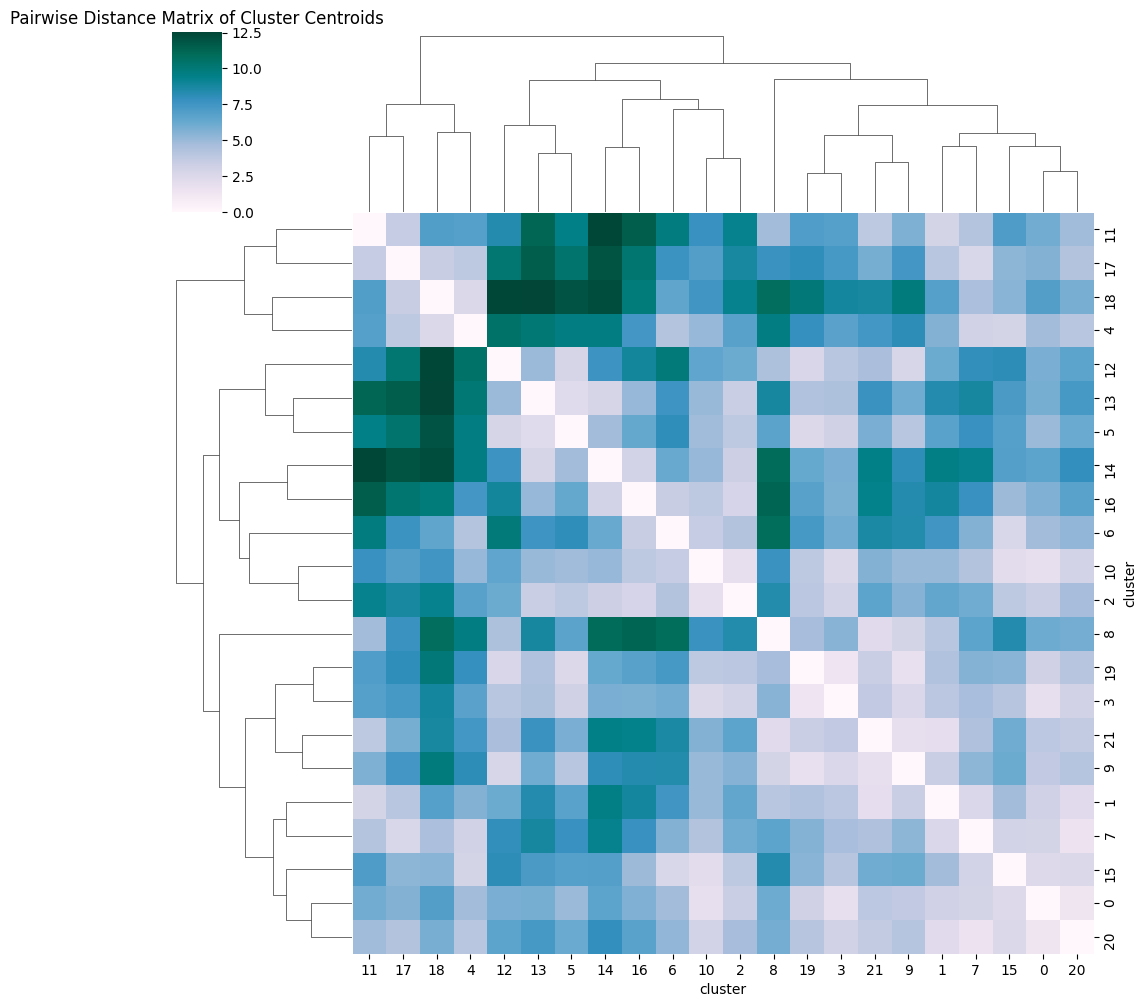

In [ ]:
mde_strong_degs_8 = tf_compute_MDE(adata_strong_degs, label_points=False, spectral=True, leiden_neighbors=8)

In [ ]:
_, _, _, _, embedding_strong_degs_df_8 = mde_strong_degs_8
perts_in_cluster_strong_degs_8 = gene_targets_per_cluster(embedding_strong_degs_df_8)
perts_in_cluster_strong_degs_8.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,CBX2,CENPX,ATOH1,DUXA,AIRE,CCDC17,BHLHE40,ASH1L,ANKZF1,CSRNP2,...,BCL6B,CDX1,ARNT2,CHAMP1,BHLHE41,ADNP2,GTF3A,ASCL5,FOXJ2,ARID3B
1,EPAS1,DLX4,ESRRA,ERG,BARX1,DEAF1,CREBL2,FOXN2,ATOH7,NR1H4,...,DMRT2,EHF,EBF3,DNMT1,CREB5,BSX,HOXD13,BHLHA9,GATA5,BARHL1
2,FOXK1,FOXA1,FOXD4L5,MTF2,DACH2,ESRRB,DMRTA2,GATAD2A,CEBPA,SOX1,...,FIGLA,IRF4,ESR1,IRX5,HES4,CAMTA2,NR1D1,HNF1B,THAP6,HLF
3,GATA6,FOXD3,FOXE3,MXI1,EBF2,GATAD2B,FOXD4,HIVEP2,GATA1,THRB,...,PRDM8,PREB,ETV5,MITF,IKZF5,ERF,PHF20,MECOM,ZBTB26,MKX
4,GSC,FOXH1,HES6,NR1I3,GMEB2,KMT2B,HES3,MTERF1,HHEX,TIGD6,...,SP8,SP1,LIN28B,PITX3,NME2,ETS1,PKNOX2,MSX2,ZNF200,ONECUT3


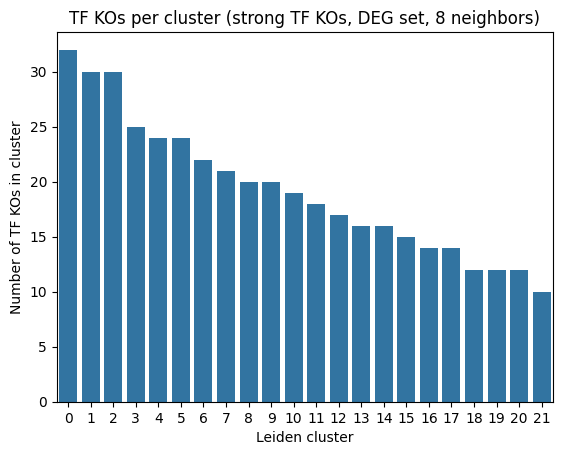

In [ ]:
_ = plot_n_perts_per_cluster(perts_in_cluster_strong_degs_8, "TF KOs per cluster (strong TF KOs, DEG set, 8 neighbors)")

In [ ]:
perts_in_cluster_strong_degs_8.to_csv("/home/ranwyl/results_tf_project/strong_tf_ko_clust_degs_8nbrs.csv", index=False)

May 14 07:13:18 PM: Fitting a centered embedding into R^2, for a graph with 402 items and 75761 edges.
May 14 07:13:18 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
May 14 07:13:18 PM: iteration 0000 | distortion 0.609670 | residual norm 0.0600243 | step length 22.7453 | percent change 4.81495
May 14 07:13:19 PM: iteration 0100 | distortion 0.145866 | residual norm 0.000122541 | step length 1 | percent change 1.0716
May 14 07:13:20 PM: iteration 0200 | distortion 0.144861 | residual norm 0.000123515 | step length 1 | percent change 0.410095
May 14 07:13:21 PM: iteration 0300 | distortion 0.144701 | residual norm 3.70271e-05 | step length 1 | percent change 0.0947483
May 14 07:13:22 PM: Converged in 400 iterations, with residual norm 9.75202e-06
May 14 07:13:22 PM: Finished fitting in 4.579 seconds and 400 iterations.
May 14 07:13:22 PM: average distortion 0.145 | residual norm 9.8e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



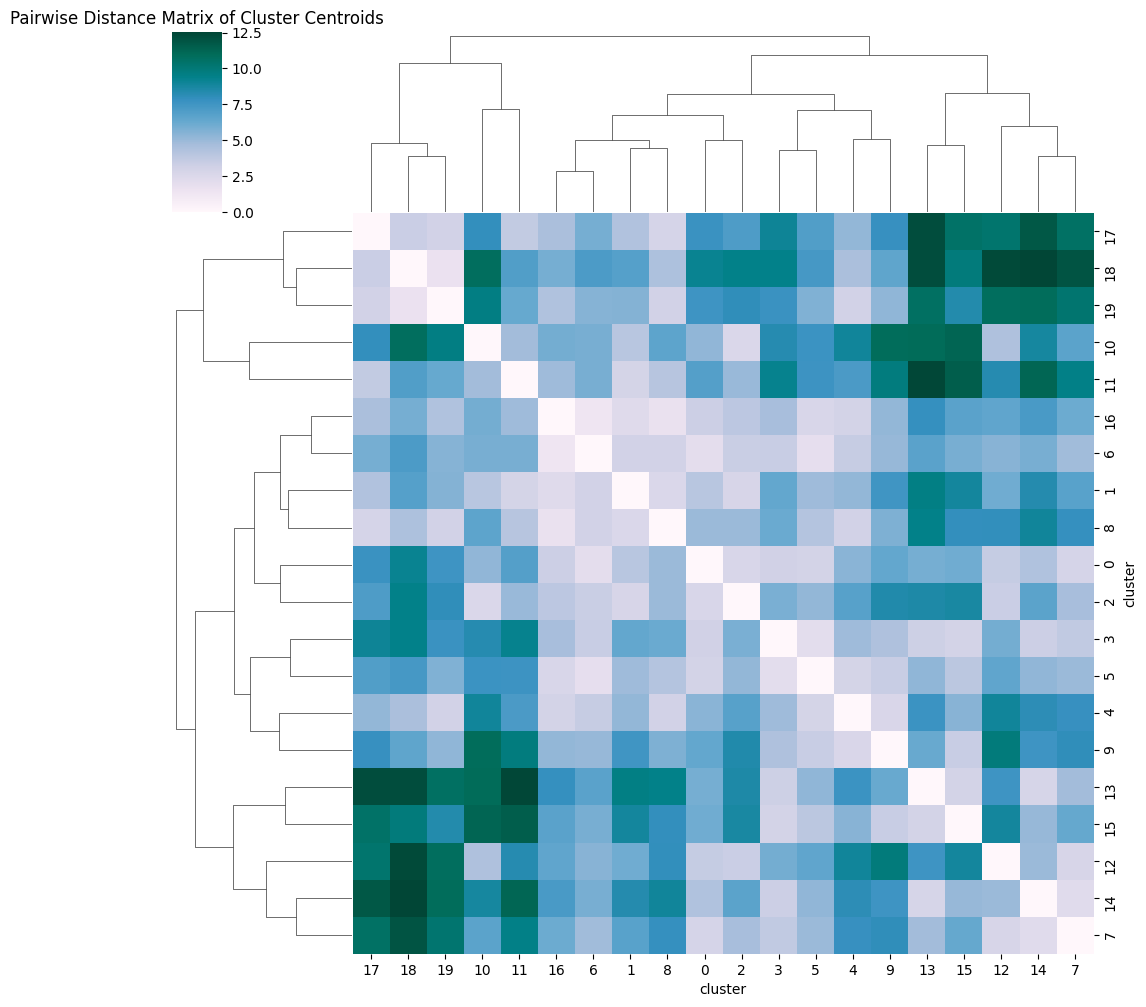

In [ ]:
mde_strong_degs_10 = tf_compute_MDE(adata_strong_degs, label_points=False, spectral=True, leiden_neighbors=10)

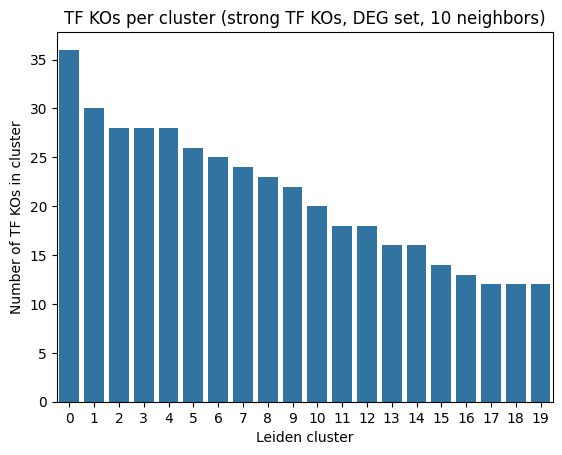

In [ ]:
_, _, _, _, embedding_strong_degs_df_10 = mde_strong_degs_10
perts_in_cluster_strong_degs_10 = gene_targets_per_cluster(embedding_strong_degs_df_10)
_ = plot_n_perts_per_cluster(perts_in_cluster_strong_degs_10, "TF KOs per cluster (strong TF KOs, DEG set, 10 neighbors)")

In [ ]:
perts_in_cluster_strong_degs_10.to_csv("/home/ranwyl/results_tf_project/strong_tf_ko_clust_degs_10nbrs.csv", index=False)

### MDE on 2000 HVG dataset

May 14 07:13:56 PM: Fitting a centered embedding into R^2, for a graph with 402 items and 75356 edges.
May 14 07:13:56 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
May 14 07:13:56 PM: iteration 0000 | distortion 0.546280 | residual norm 0.0441499 | step length 30.1494 | percent change 4.69441
May 14 07:13:57 PM: iteration 0100 | distortion 0.142096 | residual norm 5.77145e-05 | step length 1 | percent change 0.210909
May 14 07:13:58 PM: iteration 0200 | distortion 0.141486 | residual norm 5.88234e-05 | step length 1 | percent change 0.429924
May 14 07:13:59 PM: iteration 0300 | distortion 0.140797 | residual norm 6.7573e-05 | step length 1 | percent change 0.119234
May 14 07:14:01 PM: Converged in 384 iterations, with residual norm 9.82149e-06
May 14 07:14:01 PM: Finished fitting in 4.550 seconds and 384 iterations.
May 14 07:14:01 PM: average distortion 0.141 | residual norm 9.8e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



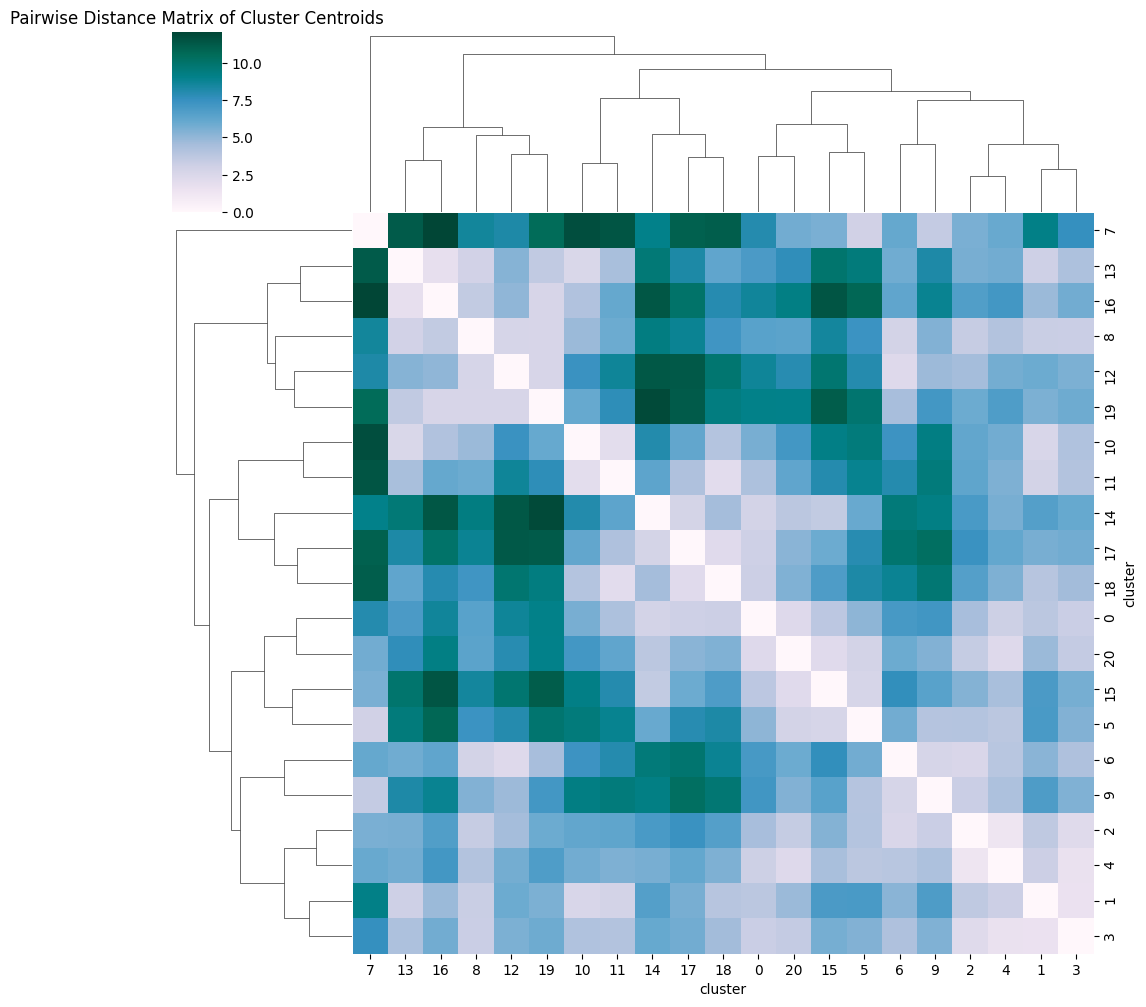

In [ ]:
mde_strong_hvgs_8 = tf_compute_MDE(adata_strong_hvgs, label_points=False, spectral=True, leiden_neighbors=8)

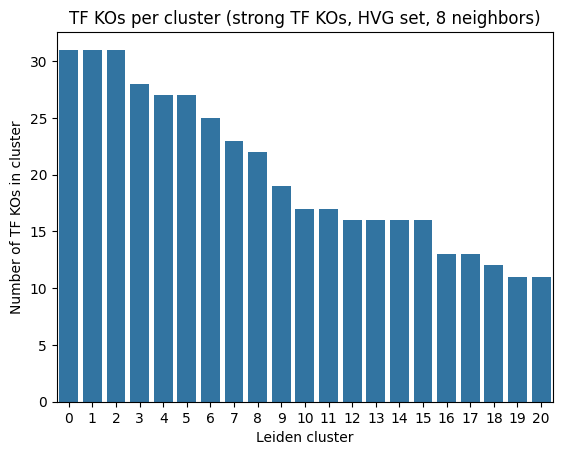

In [ ]:
_, _, _, _, embedding_df_strong_hvgs_8 = mde_strong_hvgs_8
perts_in_cluster_strong_hvgs_8 = gene_targets_per_cluster(embedding_df_strong_hvgs_8)
plot_n_perts_per_cluster(perts_in_cluster_strong_hvgs_8, "TF KOs per cluster (strong TF KOs, HVG set, 8 neighbors)")

In [ ]:
perts_in_cluster_strong_hvgs_8.to_csv("/home/ranwyl/results_tf_project/strong_tf_ko_clust_hvgs_8nbrs.csv", index=False)

10 Leiden neighbors

May 14 07:14:41 PM: Fitting a centered embedding into R^2, for a graph with 402 items and 75356 edges.
May 14 07:14:41 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
May 14 07:14:41 PM: iteration 0000 | distortion 0.546280 | residual norm 0.0441499 | step length 30.1494 | percent change 4.69441
May 14 07:14:42 PM: iteration 0100 | distortion 0.142096 | residual norm 5.77145e-05 | step length 1 | percent change 0.210909
May 14 07:14:43 PM: iteration 0200 | distortion 0.141486 | residual norm 5.88234e-05 | step length 1 | percent change 0.429924
May 14 07:14:45 PM: iteration 0300 | distortion 0.140797 | residual norm 6.7573e-05 | step length 1 | percent change 0.119234
May 14 07:14:46 PM: Converged in 384 iterations, with residual norm 9.82149e-06
May 14 07:14:46 PM: Finished fitting in 5.704 seconds and 384 iterations.
May 14 07:14:46 PM: average distortion 0.141 | residual norm 9.8e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



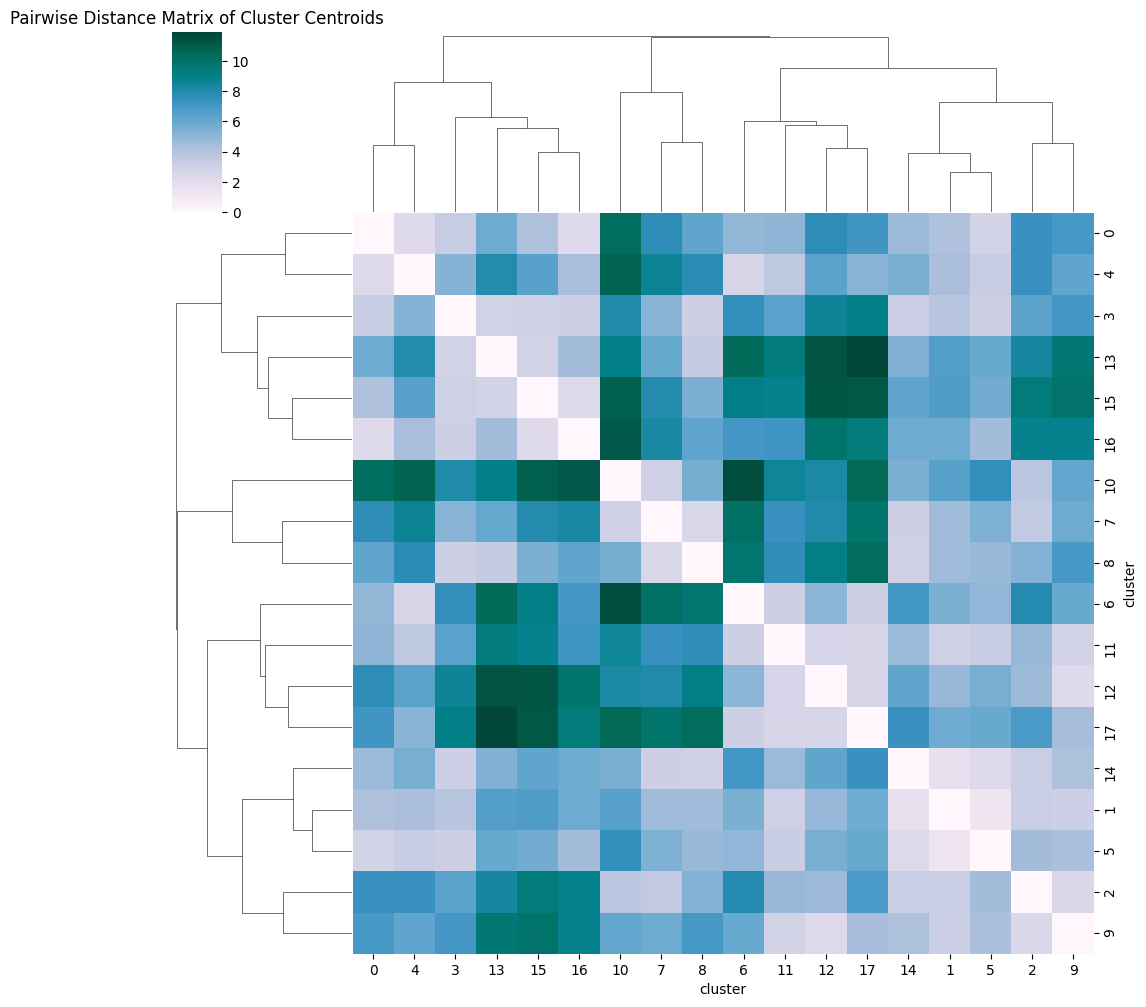

In [ ]:
mde_strong_hvgs_10 = tf_compute_MDE(adata_strong_hvgs, label_points=False, spectral=True, leiden_neighbors=10)

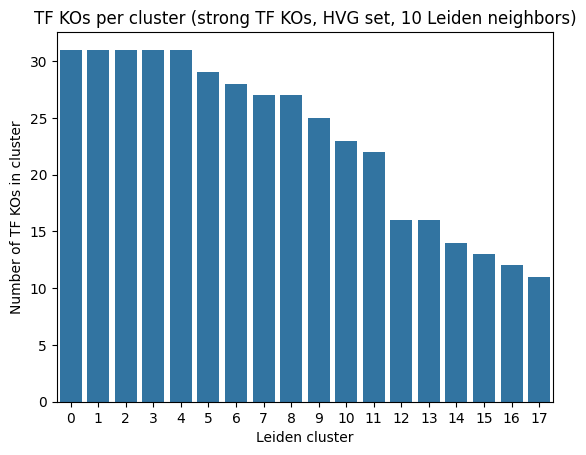

In [ ]:
_, _, _, _, embedding_df_strong_hvgs_10 = mde_strong_hvgs_10
perts_in_cluster_strong_hvgs_10 = gene_targets_per_cluster(embedding_df_strong_hvgs_10)
plot_n_perts_per_cluster(perts_in_cluster_strong_hvgs_10, "TF KOs per cluster (strong TF KOs, HVG set, 10 Leiden neighbors)")

In [ ]:
perts_in_cluster_strong_hvgs_10.to_csv("/home/ranwyl/results_tf_project/strong_tf_ko_clust_hvgs_10nbrs.csv", index=False)

### Compare TF KO cluster membership between two datasets

In [ ]:
def compare_cluster_dfs(df1, df1_name, df2, df2_name):
    """
    Given two DataFrames where each column represents a TF KO cluster, 
    compare each TF KO cluster in df1 to each TF KO cluster in df2 using Jaccard similarity. 
    Output two DataFrames, one recording the Jaccard similarity
    and one recording the size of the set intersection between the two clusters.
    """
    dict1 = {int(col): df1[col].tolist() for col in df1.columns}
    dict2 = {int(col): df2[col].tolist() for col in df2.columns}
    jaccard_array = np.zeros((len(dict1), len(dict2)))
    intersection_array = np.zeros((len(dict1), len(dict2)), dtype=int)
    for i, perts1 in sorted(dict1.items()):
        set1 = set(perts1)
        for j, perts2 in sorted(dict2.items()):
            set2 = set(perts2)
            # Compute Jaccard index
            intersection = len(set1.intersection(set2))
            union = len(set1.union(set2))
            jaccard_array[i, j] = round(intersection/union, 3) if union != 0 else 0
            # Record intersection
            intersection_array[i, j] = intersection
    # Create DataFrame
    row_names = [f"{df1_name}_CL_{i}" for i in range(len(dict1))]
    col_names = [f"{df2_name}_CL_{j}" for j in range(len(dict2))]
    jaccard_df = pd.DataFrame(jaccard_array, columns=col_names, index=row_names)
    intersection_df = pd.DataFrame(intersection_array, columns=col_names, index=row_names)
    return jaccard_df, intersection_df

In [ ]:
jaccard_strong8, intersection_strong8 = \
    compare_cluster_dfs(perts_in_cluster_strong_degs_8, "DEG", perts_in_cluster_strong_hvgs_8, "HVG")

In [ ]:
def cluster_heatmap(cluster_comparison_df, rows_name, cols_name, title, v_min, v_max, color_map="rocket_r"):
    row_names = [i for i in range(cluster_comparison_df.shape[0])]
    col_names = [j for j in range(cluster_comparison_df.shape[1])]
    df = pd.DataFrame(cluster_comparison_df.values, columns=col_names, index=row_names)
    if v_min or v_max:
        ax = sns.heatmap(df, vmin=v_min, vmax=v_max, cmap=color_map)
    else:
        ax = sns.heatmap(df, cmap=color_map)
    ax.set_ylabel(rows_name)
    ax.set_xlabel(cols_name)
    ax.set_title(title)

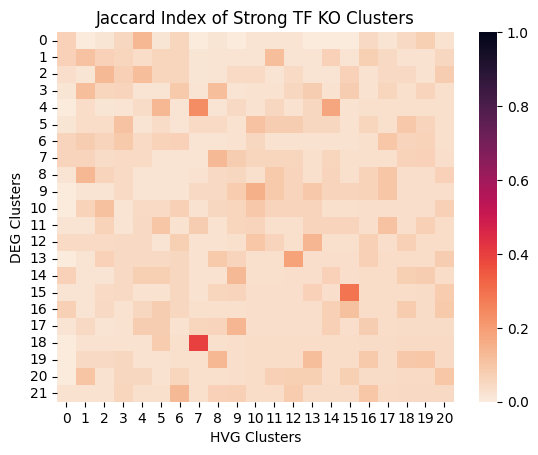

In [ ]:
p = cluster_heatmap(jaccard_strong8, rows_name="DEG Clusters", cols_name="HVG Clusters",
    title="Jaccard Index of Strong TF KO Clusters", v_min=0, v_max=1, color_map="rocket_r")

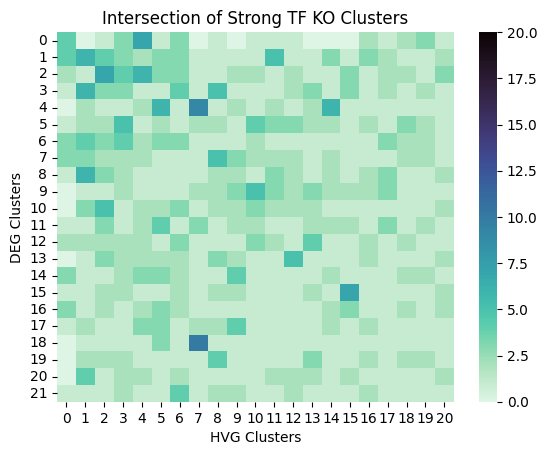

In [ ]:
p = cluster_heatmap(intersection_strong8, rows_name="DEG Clusters", cols_name="HVG Clusters",
    title="Intersection of Strong TF KO Clusters", v_min=0, v_max=20, color_map="mako_r")

Now we will compare to the Mali Lab strong perturbation dataset clusters, specifically the TF KOs in each cluster. These clusters were generated using the TF project deterministic code that seeded all nondeterministic functions.

In [ ]:
mali_clusters = pd.read_csv("/home/ranwyl/results_tf_project/mali_lab_tf_ko_clusters_deterministic.csv", index_col=0)

In [ ]:
mali_clusters.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,FOXK1,NaN,BHLHA9,ASCL5,DMRT2,ANKZF1,E2F4,CREM,ELK1,AKAP8L,...,NKX6-2,PHF20,ZBTB42,DR1,NaN,ARHGAP35,NaN,KLF1,HOXD13,ZNF253
1,GATA5,NaN,DUXA,ATOH1,NFIL3,CSRNP2,ETS1,FOXK2,NaN,IKZF5,...,SP1,POU3F2,ZNF549,DRAP1,NaN,ETV1,NaN,NANOG,NR1D1,NaN
2,MSANTD4,NaN,ESR2,ESRRA,ZNF16,FOXA1,FOXH1,ZNF563,NaN,TCF7L2,...,NaN,POU5F1,NaN,NaN,NaN,HHEX,NaN,NANOGP8,RBPJ,NaN
3,NOTO,NaN,ETS2,FOXE3,ZNF735,GATAD2A,POU2F1,NaN,NaN,ZNF44,...,NaN,POU5F1B,NaN,NaN,NaN,NaN,NaN,PRDM14,TCF12,NaN
4,NR0B1,NaN,ISL1,GLIS3,NaN,HNF1B,SMAD4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PURG,ZNF396,NaN


Reorder Mali lab columns from longest to shortest before plotting

In [ ]:
def reorder_columns(df):
    """
    Reorder columns from longest to shortest and remove columns with < 2 items.
    """
    # Create tuples (column_name, length)
    col_lengths = [(i, col.count()) for i, col in df.items()]
    # Sort tuples by length
    col_lengths = list(sorted(col_lengths, key=lambda x: x[1], reverse=True))
    # Reorder columns
    col_order = [col[0] for col in col_lengths if col[1] > 1]
    new_df = df.loc[:, col_order]
    # Create dict for renumbering columns
    col_renumbering = {col_order[i]: i for i in range(len(col_order))}
    # Renumber columns
    new_df = new_df.rename(columns=col_renumbering)
    return new_df, col_renumbering

In [ ]:
mali_clusters_reordered, mali_columns_reordered = reorder_columns(mali_clusters)

In [ ]:
jaccard_deg_mali_reordered_strong, intersection_deg_mali_reordered_strong = \
    compare_cluster_dfs(perts_in_cluster_strong_degs_8, "DEG", mali_clusters_reordered, "Mali_r")

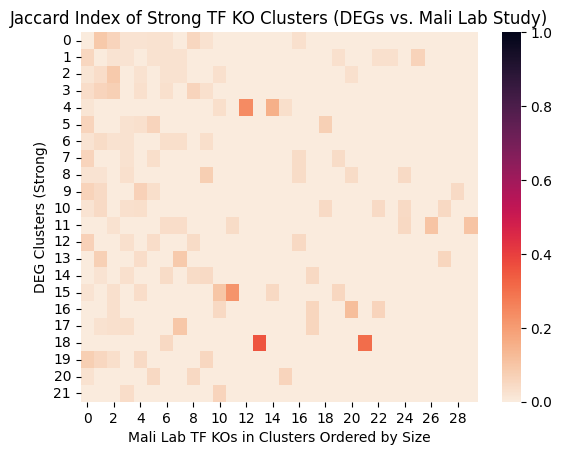

In [ ]:
p = cluster_heatmap(jaccard_deg_mali_reordered_strong, rows_name="DEG Clusters (Strong)", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
    title="Jaccard Index of Strong TF KO Clusters (DEGs vs. Mali Lab Study)", v_min=0, v_max=1, color_map="rocket_r")

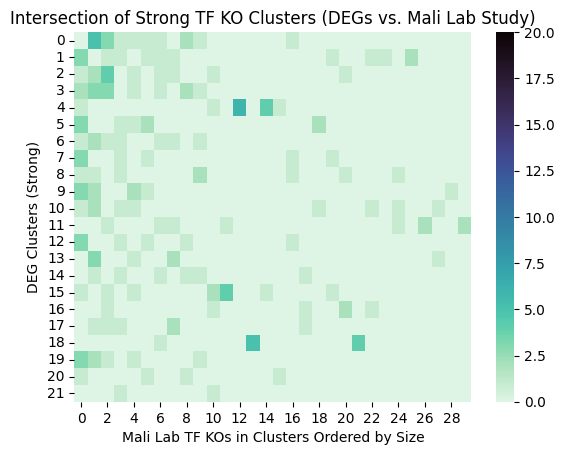

In [ ]:
p = cluster_heatmap(intersection_deg_mali_reordered_strong, rows_name="DEG Clusters (Strong)", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
    title="Intersection of Strong TF KO Clusters (DEGs vs. Mali Lab Study)", v_min=0, v_max=20, color_map="mako_r")

In [ ]:
jaccard_hvg_mali_reordered_strong, intersection_hvg_mali_reordered_strong = \
    compare_cluster_dfs(perts_in_cluster_strong_hvgs_8, "HVG", mali_clusters_reordered, "Mali_r")

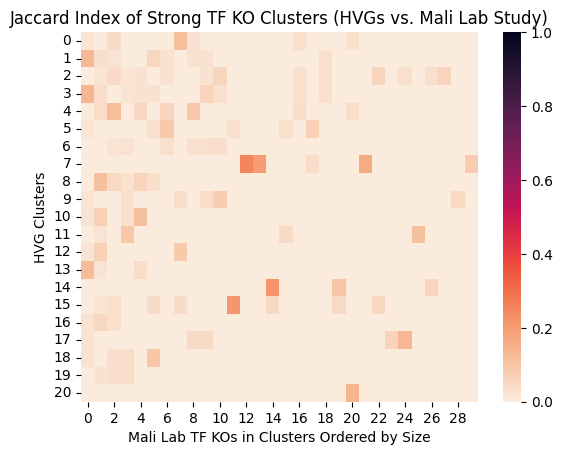

In [ ]:
p = cluster_heatmap(jaccard_hvg_mali_reordered_strong, rows_name="HVG Clusters", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
    title="Jaccard Index of Strong TF KO Clusters (HVGs vs. Mali Lab Study)", v_min=0, v_max=1, color_map="rocket_r")

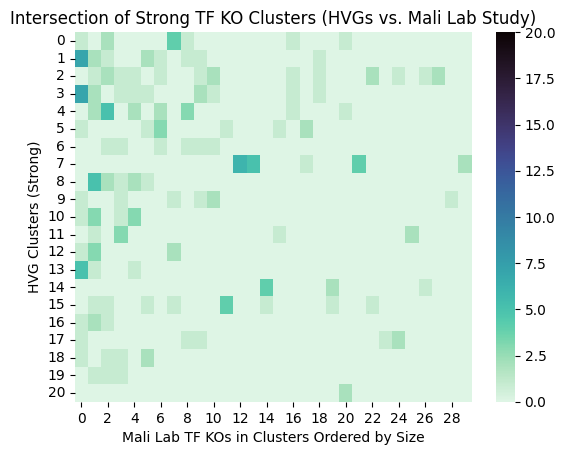

In [ ]:
p = cluster_heatmap(intersection_hvg_mali_reordered_strong, rows_name="HVG Clusters (Strong)", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
    title="Intersection of Strong TF KO Clusters (HVGs vs. Mali Lab Study)", v_min=0, v_max=20, color_map="mako_r")

## Overrepresentation analysis (ORA)

We seek to functionally annotate each TF KO cluster using overrepresentation analysis (ORA), which is performed on a user-submitted list of DEGs. For any given TF KO cluster, every TF KO in the cluster will have its own DEGs, and we want to generate a set of upregulated genes and a set of downregulated genes that represents the cluster.

Here we will try the following approach for each TF KO cluster. First, read in the full DE results, subset the results for the TF KOs in the cluster, and filter only genes with p-adj < 0.05. Next, for each TF KO, take the top n upregulated genes (i.e. the n genes with the highest LFC). Then take the intersection of the n genes per TF KO.

We will try this with the clusters from the MDE generated using 5087 DEGs as features and 8 nearest neighbors in the neighborhood graph for Leiden clustering.

Read in differential expression analysis results from TF KO and NTC dataset (85% sample fraction, LFC shrinkage performed with adapt=False)

In [2]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")

In [3]:
de_results.head()

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,5.197361,0.603388,0.610262,1.249251,0.211573,NaN,3.271476,-0.219247,0.719732,-0.436204,...,0.928560,-1.333630,0.182325,0.93709,3.431164,-0.557770,0.756780,-1.045982,0.295569,0.943485
A1BG-AS1,2.117718,0.544581,0.911720,0.986719,0.323780,NaN,0.659727,-0.021330,1.140542,-0.048274,...,1.246887,-0.863337,0.387952,0.93709,0.627773,-0.762906,1.404104,-1.112549,0.265902,0.943485
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.349860,-0.390388,1.225741,-0.692164,0.488835,NaN,0.826464,-0.187075,1.073352,-0.401825,...,1.930966,1.844563,0.065101,0.93709,0.643332,0.025018,1.154267,0.060363,0.951867,0.979964
A2M-AS1,0.311871,0.340470,1.828676,0.582373,0.560315,NaN,0.976668,0.678086,1.342768,1.186024,...,1.135588,-0.197266,0.843620,0.93709,0.823219,0.181208,1.157592,0.401337,0.688172,0.943485


In [4]:
clusters = pd.read_csv("/home/ranwyl/results_tf_project/strong_tf_ko_clust_degs_8nbrs.csv")

In [5]:
clusters.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,CBX2,CENPX,ATOH1,DUXA,AIRE,CCDC17,BHLHE40,ASH1L,ANKZF1,CSRNP2,...,BCL6B,CDX1,ARNT2,CHAMP1,BHLHE41,ADNP2,GTF3A,ASCL5,FOXJ2,ARID3B
1,EPAS1,DLX4,ESRRA,ERG,BARX1,DEAF1,CREBL2,FOXN2,ATOH7,NR1H4,...,DMRT2,EHF,EBF3,DNMT1,CREB5,BSX,HOXD13,BHLHA9,GATA5,BARHL1
2,FOXK1,FOXA1,FOXD4L5,MTF2,DACH2,ESRRB,DMRTA2,GATAD2A,CEBPA,SOX1,...,FIGLA,IRF4,ESR1,IRX5,HES4,CAMTA2,NR1D1,HNF1B,THAP6,HLF
3,GATA6,FOXD3,FOXE3,MXI1,EBF2,GATAD2B,FOXD4,HIVEP2,GATA1,THRB,...,PRDM8,PREB,ETV5,MITF,IKZF5,ERF,PHF20,MECOM,ZBTB26,MKX
4,GSC,FOXH1,HES6,NR1I3,GMEB2,KMT2B,HES3,MTERF1,HHEX,TIGD6,...,SP8,SP1,LIN28B,PITX3,NME2,ETS1,PKNOX2,MSX2,ZNF200,ONECUT3


In [15]:
def get_cluster_degs(cluster_num, cluster_df, de_df, n_degs_per_tf_ko, padj_threshold, lfc_threshold):
    """
    Generate a set of DEGs with p-adj < padj_threshold and |LFC| > lfc_threshold 
    for cluster number cluster_num in cluster_df, based on the DE results of de_df.
    """
    # Change cluster number to string
    if type(cluster_num) is not str:
        cluster_num = str(cluster_num)
    # Get TF KOs in cluster column (excluding NaN values)
    cluster_tf_ko_list = cluster_df[cluster_num][cluster_df[cluster_num].notna()].tolist()
    # Filter DE DF to only TF KOs
    de_df_cols = [col for col in de_df.columns if any(f"{tf_ko}_" in col for tf_ko in cluster_tf_ko_list)]
    de_df = de_df[de_df_cols]
    # Get top n upregulated and top n downregulated DEGs per TF KO
    up_degs_sets = list()
    down_degs_sets = list()
    for tf_ko in cluster_tf_ko_list:
        tf_ko_de_df = de_df.filter(like=f"{tf_ko}_", axis=1)
        # Filter by p-adj and LFC thresholds
        tf_ko_de_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_padj"] < padj_threshold]
        print(f"Genes that pass p-adj threshold {tf_ko_de_df.shape[0]}")
        tf_ko_de_df = tf_ko_de_df[abs(tf_ko_de_df[f"{tf_ko}_log2FoldChange"]) > lfc_threshold]
        print(f"Genes that pass LFC threshold {tf_ko_de_df.shape[0]}")
        # Top upregulated DEGs
        tf_ko_up_deg_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_log2FoldChange"] > 0]
        tf_up_degs = tf_ko_up_deg_df.nlargest(n_degs_per_tf_ko, f"{tf_ko}_log2FoldChange", keep="all").index.tolist()
        if tf_up_degs:
            up_degs_sets.append(set(tf_up_degs))
        # Top downregulated DEGs
        tf_ko_down_deg_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_log2FoldChange"] < 0]
        tf_down_degs = tf_ko_down_deg_df.nsmallest(n_degs_per_tf_ko, f"{tf_ko}_log2FoldChange", keep="all").index.tolist()
        if tf_down_degs:
            down_degs_sets.append(set(tf_down_degs))
    # Get intersection of all top n DEGs
    up_degs = set.intersection(*up_degs_sets)
    print(f"{len(up_degs)} upregulated DEGs in intersection of all sets")
    down_degs = set.intersection(*down_degs_sets)
    print(f"{len(down_degs)} downregulated DEGs in intersection of all sets")
    return up_degs_sets, down_degs_sets

def display_deg_results(up_degs_sets, down_degs_sets):
    results = list()
    results = [[len(s) for s in up_degs_sets], [len(s) for s in down_degs_sets]]
    results_df = pd.DataFrame(results, index=["upregulated", "downregulated"])
    # Get intersection of all top n DEGs
    up_degs = set.intersection(*up_degs_sets)
    print(f"{len(up_degs)} upregulated DEGs found")
    down_degs = set.intersection(*down_degs_sets)
    print(f"{len(down_degs)} downregulated DEGs found")
    return results_df

In [7]:
test_up, test_down = get_cluster_degs(0, clusters, de_results, 200, 0.05, 0.25)

Genes that pass p-adj threshold 112
Genes that pass LFC threshold 85
Genes that pass p-adj threshold 183
Genes that pass LFC threshold 147
Genes that pass p-adj threshold 114
Genes that pass LFC threshold 106
Genes that pass p-adj threshold 33
Genes that pass LFC threshold 28
Genes that pass p-adj threshold 63
Genes that pass LFC threshold 60
Genes that pass p-adj threshold 33
Genes that pass LFC threshold 31
Genes that pass p-adj threshold 118
Genes that pass LFC threshold 97
Genes that pass p-adj threshold 123
Genes that pass LFC threshold 62
Genes that pass p-adj threshold 30
Genes that pass LFC threshold 27
Genes that pass p-adj threshold 246
Genes that pass LFC threshold 219
Genes that pass p-adj threshold 67
Genes that pass LFC threshold 59
Genes that pass p-adj threshold 235
Genes that pass LFC threshold 234
Genes that pass p-adj threshold 56
Genes that pass LFC threshold 48
Genes that pass p-adj threshold 50
Genes that pass LFC threshold 34
Genes that pass p-adj threshold 45
Ge

In [16]:
results_df = display_deg_results(test_up, test_down)

0 upregulated DEGs found
0 downregulated DEGs found


In [17]:
display(results_df)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
upregulated,22,32,37,14,19,7,32,20,16,99,...,28,9,8,87,34,16,15,65,2,13
downregulated,63,115,69,14,41,24,65,42,11,120,...,59,34,23,101,110,34,34,89,20,37


In [11]:
def filter_deg_sets(up_degs_sets, down_degs_sets, cutoff):
    up_degs_sets = [s for s in up_degs_sets if len(s) > cutoff]
    down_degs_sets = [s for s in down_degs_sets if len(s) > cutoff]
    # Get intersection of all top n DEGs
    up_degs = set.intersection(*up_degs_sets)
    print(f"{len(up_degs)} upregulated DEGs found")
    down_degs = set.intersection(*down_degs_sets)
    print(f"{len(down_degs)} downregulated DEGs found")

In [14]:
filter_deg_sets(test_up, test_down, 20)

0 upregulated DEGs found
0 downregulated DEGs found
